## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import gc

import random
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import namedtuple, deque

from simulation import Simulator, coordinate

## Simulator Setup

In [2]:
def reset_sim():
    # Units are pixels for resolution, degrees for fov, degrees for angle, and pixels for height.
    img_size = (128, 72)
    cameraSettings = {
        # "resolution": (1920, 1080),
        "resolution": img_size,
        "fov": {"diagonal": 77}, # realsense diagonal fov is 77 degrees IIRC
        "angle": {"roll": 0, "pitch": 0, "yaw": 0}, # don't go too crazy with these, my code should be good up to like... 45 degrees probably? But the math gets unstable
        # "angle": {"roll": 13, "pitch": 30, "yaw": 30}, # don't go too crazy with these, my code should be good up to like... 45 degrees probably? But the math gets unstable
        "height": 66 # 8 pixels/inch - represents how high up the camera is relative to the road
    }

    mapParameters = {
        "loops": 1,
        "size": (6, 6),
        "expansions": 5,
        "complications": 4
    }

    # Can also pass car parameters for max/min speed, etc
    carParameters = {
        "wheelbase": 6.5, # inches, influences how quickly the steering will turn the car.  Larger = slower
        "maxSteering": 30.0, # degrees, extreme (+ and -) values of steering
        "steeringOffset": 0.0, # degrees, since the car is rarely perfectly aligned
        "minVelocity": 0.0, # pixels/second, slower than this doesn't move at all.
        "maxVelocity": 480.0, # pixels/second, 8 pixels/inch, so if the car can move 5 fps that gives us 480 pixels/s top speed
    }

    sim = Simulator(cameraSettings=cameraSettings)

    startLocations = np.array([[0,1], [0,2], [0,3], [0,4], [0,5], [0,6], [0,7], [1,0], [1,1], [1,4], [1,7], [2,2], [2,3], [1,4], [2,5], [2,6], [2,0], [5,1], [3,2], [2,4], [5,5], [5,6], [2,7], [3,0], [7,1], [4,2], [7,3], [5,4], [6,5], [3,7], [4,0], [5,2], [7,4], [7,5], [4,7], [5,0], [7,2], [5,7], [6,0]])
    startLoc = random.randint(0, 38)

    sim.start(mapSeed='real', mapParameters=mapParameters, carParameters=carParameters, startPoint=(int(startLocations[startLoc, 0]),int(startLocations[startLoc, 1]),0,0))
    # sim.start(mapSeed='real', mapParameters=mapParameters, carParameters=carParameters, startPoint=(0,4,0,0))
    
    where, facing = sim.RealSense.parent.ackermann.pose()
    initial_img = sim.RealSense.camera.getImage(where, facing)
    return sim, initial_img

From here, the API for using the simulation is as follows. Steps the entire simulation, returns image, reward from sim.getReward() and a done bool (and we can change what 'done' means. Currently its if reward is negative):

```python
frame, reward, done = sim.step(steer, speed, display=False) 
```

In order to reset the simulation, you just need to reconstruct the sim object and start it, using the reset_sim() function above.

# DQN

## Part 1

Deep Q-Network (https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) is a Q-learning algorithm that learns values for state-action pairs.

Actions are sampled according to an $\epsilon-greedy$ policy to help with exploration of the state space. Every time an action is sampled, the agent chooses a random action with $\epsilon$ probability. Otherwise, the agent selects the action with the highest Q-value for a state. $\epsilon$ decays over time according to $\epsilon \gets \epsilon * epsilon\_decay$.

Tuples of state, action, reward, next_state, and terminal $(s,a,r,s',d)$ are collected during training. Every $learn\_frequency$ steps $sample\_size$ tuples are sampled and made into 5 tensors tensors of states, actions, rewarads, next_states, and terminals.

The loss for a batch of size N is given below.

$Loss=\frac{1}{N}\sum \bigg(Q(s,a) - (r + \gamma \underset{a'\sim A}{max} \hat{Q}(s',a')(1-d))\bigg)^2 $

Loss is calculated and used to update the Q-Network. The target network $\hat{Q}$ begins as a copy of the Q network but is not updated by the optimizer. Every $target\_update$ steps, the target network is updated with the parameters of the Q-Network. This process is a type of bootstrapping.

In [3]:
# Q-Value Network
class QNetwork(nn.Module):
  def __init__(self, action_size=7, in_channels=3, cnn_outchannels=1, hidden_size=128):
    super().__init__()
  
    self.cnn = nn.Sequential(
                            nn.Conv2d(in_channels=in_channels, out_channels=cnn_outchannels*16, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=cnn_outchannels*16, out_channels=cnn_outchannels*32, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=cnn_outchannels*32, out_channels=cnn_outchannels, kernel_size=3, stride=1, padding=1),
                            nn.ReLU()
                            )

    self.controller = nn.Sequential(
                            nn.Linear(128*72, hidden_size),
                            nn.ReLU(),
                            nn.Linear(hidden_size, action_size)
                            )

    
  def forward(self, img_batch):
    """Estimate q-values given image
      Args:
          img batch (4d tensor): size (batch_size, height, width, channel)

      Returns:
          q-values (tensor): estimated q-values, size (batch x action_size)
    """
    cnn_output = self.cnn(img_batch.permute([0, 3, 1, 2]))
    return self.controller(cnn_output.view(cnn_output.size(0), -1))

In [4]:
Transition = namedtuple('Transition',
                        ('frame', 'action', 'next_frame', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
def get_action_dqn(network, frame, epsilon, epsilon_decay, action_size, global_steps, REPLAY_SIZE):
  """Select action according to e-greedy policy and decay epsilon

    Args:
        network (QNetwork): Q-Network
        state (np-array): current state, size (state_size)
        epsilon (float): probability of choosing a random action
        epsilon_decay (float): amount by which to decay epsilon

    Returns:
        action (int): chosen action [0, action_size)
        epsilon (float): decayed epsilon
  """
  if random.uniform(0., 1.) < np.max(0.1, epsilon) or global_steps < REPLAY_SIZE:
    action = random.randint(0,action_size-1) #randint 0-action_space size corresponding to [-30,-20,-10,0,10,20,30] degrees
    action = torch.tensor(action).view(1,1)
  else:
    with torch.no_grad():
      action = network(frame).max(1)[1].view(1, 1)
  return action.cuda(), epsilon*epsilon_decay

  
def learn_dqn(memory_buffer, batch_size, optim, q_network, target_network, gamma, episode, target_update):
  """Update Q-Network according to DQN Loss function
     Update Target Network every target_update global steps

    Args:
        batch (tuple): tuple of state, action, next_state, reward, and done tensors
        optim (Adam): Q-Network optimizer
        q_network (QNetwork): Q-Network
        target_network (QNetwork): Target Q-Network
        gamma (float): discount factor
        episode (int): total steps taken in environment
        target_update (int): frequency of target network update
  """
  transitions = memory_buffer.sample(batch_size)
  batch = Transition(*zip(*transitions))

  non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_frame)), dtype=torch.bool).cuda()
  non_final_next_states = torch.cat([s for s in batch.next_frame
                                          if s is not None])

  frame_batch = torch.cat(batch.frame)
  action_batch = torch.cat(batch.action).long()
  reward_batch = torch.cat(batch.reward)

  Q = q_network(frame_batch).gather(1, action_batch)

  Q_hat = torch.zeros(batch_size).cuda()
  with torch.no_grad():
      Q_hat[non_final_mask] = target_network(non_final_next_states).max(1)[0]

  b = reward_batch + gamma*Q_hat
  Q = torch.squeeze(Q)
  
  loss = F.mse_loss(Q, b)
  optim.zero_grad()
  loss.backward()

  torch.nn.utils.clip_grad_value_(q_network.parameters(), 100)
  optim.step()

  if episode % target_update == 0:
    target_network.load_state_dict(q_network.state_dict())


### Main

In [6]:
def dqn_main(episodes, target_update, save_frequency, START_TRAINING, MAX_EPISODE_LENGTH, LEARN_FREQUENCY, BATCH_SIZE, SAVE_REWARD_THRESHOLD, CAR_SPEED, lr, gamma, epsilon, epsilon_decay, action_space, REPLAY_SIZE):
  gc.collect()
  torch.cuda.empty_cache()

  # Init networks
  q_network = QNetwork(action_size=len(action_space)).cuda()
  target_network = QNetwork(action_size=len(action_space)).cuda()
  target_network.load_state_dict(q_network.state_dict()) # copy q_network into target_network

  # Init optimizer
  optim = torch.optim.Adam(q_network.parameters(), lr=lr)

  # Begin main loop
  reward_results_dqn = []
  episode_lengths = []
  global_step = 0
  avg_reward = 0
  prev_avg_reward = SAVE_REWARD_THRESHOLD
  loop = tqdm(total=episodes, position=0, leave=False)

  # Init episode replay buffer
  memory_buffer = ReplayMemory(100000)

  for episode in range(1, episodes):

    # Reset environment
    sim, frame = reset_sim()
    frame = torch.tensor(frame, dtype=torch.float32).unsqueeze(0).cuda()
    done = False
    cum_reward = 0  # Track cumulative reward per episode
    episode_length = 0

    # Begin episode
    while not done and cum_reward < MAX_EPISODE_LENGTH:  # End after 200 steps 
      # Select e-greedy action
      action_idx, epsilon = get_action_dqn(q_network, frame, epsilon, epsilon_decay, len(action_space), global_step, REPLAY_SIZE)

      # Take step
      observation, reward, done = sim.step(steer=action_space[action_idx], speed=CAR_SPEED, display=False)

      if done:
        next_frame = None
      else:
        next_frame = torch.tensor(observation, dtype=torch.float32).unsqueeze(0).cuda()

      reward = torch.tensor([reward]).cuda()

      # Store step in replay bufferimg
      memory_buffer.push(frame, action_idx, next_frame, reward)

      frame = next_frame  # Set current frame
      cum_reward += reward.item()
      global_step += 1
      episode_length += 1

      if (global_step > START_TRAINING) and (global_step % LEARN_FREQUENCY == 0):
        learn_dqn(memory_buffer, BATCH_SIZE, optim, q_network, target_network, gamma, episode, target_update)     # Train

    # Save the network if save_frequency steps has passed and it is better than the previous avg_reward
    avg_reward += cum_reward
    if (episode % save_frequency == 0) and global_step > episodes / 100:
      avg_reward = avg_reward / save_frequency
      if (avg_reward > prev_avg_reward + SAVE_REWARD_THRESHOLD):
        print(f"{episode} episodes completed. Average Reward: {avg_reward} > Previous Average: {prev_avg_reward}")
        torch.save(q_network, f'./rl_models/model{episode}.pt')
      prev_avg_reward = avg_reward
      avg_reward = 0

    # Print results at end of episode
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    reward_results_dqn.append(cum_reward)
    episode_lengths.append(episode_length)
    loop.update(1)
    loop.set_description('Global Steps: {:5d} Episodes: {:5d} Episode Length: {:4d} Reward: {:3.2f} Allocated Mem: {:2.2f} Reserved Mem: {:2.2f}'\
                        .format(global_step, episode, episode_length, cum_reward, a/1e9, r/1e9))
  
  print('Global Steps: {:5d} Episodes: {:5d} Ep Length: {:3d} Reward: {:3.2f} All Mem: {:2.2f} Res Mem: {:2.2f}'\
                        .format(global_step, episode, episode_length, cum_reward, a/1e9, r/1e9))
  return q_network, reward_results_dqn, episode_lengths

Global Steps: 2242136 Episodes: 24999 Ep Length: 200 Reward: 200.00 All Mem: 1.14 Res Mem: 1.71


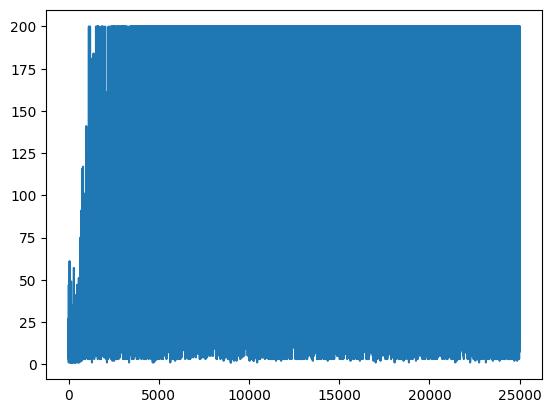

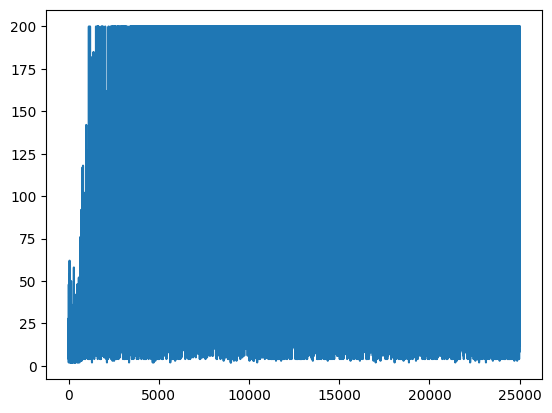

In [7]:
# Hyper parameters
# Counted by episode number
# episodes = 1000000
# target_update = 2000
# save_frequency = 1000  

# BATCH_SIZE = 32
# SAVE_REWARD_THRESHOLD = 50

# # Counted by environment time steps
# START_TRAINING = BATCH_SIZE*3
# MAX_EPISODE_LENGTH = 10000
# LEARN_FREQUENCY = 3

# CAR_SPEED = 1.4

# lr = 1e-4
# gamma = 0.99
# epsilon = 1.0
# epsilon_decay = .9999
REPLAY_SIZE = 50000

########################################################################
episodes = 100
target_update = 2000
save_frequency = 10

BATCH_SIZE = 32
SAVE_REWARD_THRESHOLD = 10

# Counted by environment time steps
START_TRAINING = BATCH_SIZE*3
MAX_EPISODE_LENGTH = 10000
LEARN_FREQUENCY = 3

CAR_SPEED = 1.4

lr = 0.00025
gamma = 0.99
epsilon = 1.0
epsilon_decay = .995
############################################################
action_space = [-30,-20,-10,0,10,20,30]
# action_space = [-30,-15,0,15,30]
# action_space = [-30,0,30]
# action_space = [-30,30]

trained_model, results_dqn, episode_lengths = dqn_main(episodes, target_update, save_frequency, START_TRAINING, MAX_EPISODE_LENGTH, LEARN_FREQUENCY, BATCH_SIZE, SAVE_REWARD_THRESHOLD, CAR_SPEED, lr, gamma, epsilon, epsilon_decay, action_space, REPLAY_SIZE)

plt.figure()
plt.plot(results_dqn)
plt.figure()
plt.plot(episode_lengths)
plt.show()

In [13]:
val_episodes = 100
episode_lengths = []

for val_episode in range(1, val_episodes):
    # Reset environment
    sim, frame = reset_sim()
    frame = torch.tensor(frame, dtype=torch.float32).unsqueeze(0).cuda()

    done = False
    episode_length = 0

    # Begin episode
    while True: 
      # Select e-greedy action
      action_idx, epsilon = get_action_dqn(trained_model, frame, 0.0, 0.0, len(action_space))

      # Take step
      observation, reward, done = sim.step(steer=action_space[action_idx], speed=CAR_SPEED, display=True)
      next_frame = torch.tensor(observation, dtype=torch.float32).unsqueeze(0).cuda()


      frame = next_frame  # Set current frame
      episode_length += 1
    
    episode_lengths.append(episode_length)
    episode_length = 0

plt.plot(episode_lengths)

In [11]:
torch.save(trained_model, f'./rl_models/working_model.pt')